# COVID-19 Visualizations

This notebook provides some basic visuals on the COVID-19 coronavirus. Data is from the European Centre for Disease Prevention and Control.

# Table of Contents
- [Import Modules](#import)
- [Setup](#setup)
- [Scrape & Download](#scrape)
- [Load Data](#load)
- [Visualizations](#viz)

# Import Modules <div id='import'/>

In [239]:
import pandas as pd
import numpy as np
from multiprocessing import Pool
import os
import configparser
import re
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
import matplotlib.dates as dates

# Setup <div id='setup'/>

In [240]:
# Bind directory references
REPO_DIR  = "/repos/covid19"
DATA_DIR  = REPO_DIR + "/data"
SOURCE_DIR = REPO_DIR + "/source"
CONFIG_DIR = REPO_DIR + "/config"

# import functions from helpers.py
os.chdir(SOURCE_DIR)
from helpers import dir_df, from_url, scrape_link
os.chdir(REPO_DIR)

# dataframe display setup
pd.set_option('display.max_columns', None)
%matplotlib inline
mplstyle.use('fivethirtyeight')

# parse config file to get url of ECDC website (having a config file is overkill for this but it is what it is)
config = configparser.ConfigParser()
config.read(CONFIG_DIR+"/covid19.cfg")
url = config['specs']['Webpage']

# Scrape & Download <div id='scrape'/>

In [241]:
# scrape download link from the ECDC website
url_down = scrape_link(url, ".xls")

# confirm that only one link is coming through
assert len(url_down)==1, "Scrape returned links to more than one .xls file"

# links come through as a list so we are taking the first
url_down = url_down[0]

# parsing the data out of the file
dt = re.findall("2020......",url_down)[0].replace("-","_",2)

# downloading the file and saving it down to the repo
from_url(url=url_down,dest=DATA_DIR+"/"+dt+"_covid19.xls")

'File not downloaded because overwrite set to False'

# Load Data <div id='load'/>

In [242]:
# compile dataframe of all data files available - usually 1 per day
file_df = dir_df(DATA_DIR)
file_df['FILE_DATE'] = file_df.FILE_NAME.str[0:10]
file_df = file_df.sort_values(by='FILE_DATE', ascending=False).reset_index(drop = True)
file_df

,FILE_NAME,FILE_PATH,FILE_SIZE,FILE_DATE
0,2020_03_15_covid19.xls,/repos/covid19/data/2020_03_15_covid19.xls,602624,2020_03_15
1,2020_03_14_covid19.xls,/repos/covid19/data/2020_03_14_covid19.xls,586752,2020_03_14
2,2020_03_13_covid19.xls,/repos/covid19/data/2020_03_13_covid19.xls,577536,2020_03_13
3,2020_03_12_covid19.xls,/repos/covid19/data/2020_03_12_covid19.xls,567808,2020_03_12


In [243]:
# Read top file & rename columns (lord knows what Gaul1Nuts1 means)
df = pd.read_excel(file_df['FILE_PATH'][0], 
                   names=["DATE_REP","COUNTRY_NAME",
                          "NEW_CASES","NEW_DEATHS",
                          "COUNTRY_ABR","GAUL1NUTS1","EU"])
# Data cleanup
df['AS_OF_DATE'] = pd.to_datetime(file_df['FILE_DATE'][0],
                                  format="%Y_%m_%d")

In [244]:
# Let's view our dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5122 entries, 0 to 5121
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   DATE_REP      5122 non-null   datetime64[ns]
 1   COUNTRY_NAME  5122 non-null   object        
 2   NEW_CASES     5122 non-null   int64         
 3   NEW_DEATHS    5115 non-null   float64       
 4   COUNTRY_ABR   5121 non-null   object        
 5   GAUL1NUTS1    500 non-null    object        
 6   EU            5122 non-null   object        
 7   AS_OF_DATE    5122 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 320.2+ KB


In [245]:
### Let's check out the top 5 rows of our dataframe
df.head()

,DATE_REP,COUNTRY_NAME,NEW_CASES,NEW_DEATHS,COUNTRY_ABR,GAUL1NUTS1,EU,AS_OF_DATE
0,2020-03-15,Afghanistan,3,0.0,AF,NaN,Non-EU/EEA,2020-03-15
1,2020-03-11,Afghanistan,3,0.0,AF,NaN,Non-EU/EEA,2020-03-15
2,2020-03-08,Afghanistan,3,0.0,AF,NaN,Non-EU/EEA,2020-03-15
3,2020-03-02,Afghanistan,0,0.0,AF,NaN,Non-EU/EEA,2020-03-15
4,2020-03-01,Afghanistan,0,0.0,AF,NaN,Non-EU/EEA,2020-03-15


# Visualizations <div id='viz'/>

## 1. Prep Data

In [246]:
# data for new cases by day worldwide (wc = world cases)
wc = df.groupby(['DATE_REP'])[['NEW_CASES','NEW_DEATHS']].sum().reset_index()

# data for EU vs non-EU cases
eu = df
eu.loc[eu['EU'] == 'EU', 'EU'] = 'EU'  
eu.loc[eu['EU'] != 'EU', 'EU'] = 'Non-EU'
eu = eu.groupby(['DATE_REP','EU'])[['NEW_CASES']].sum().reset_index()
eu_y = [np.array(eu[eu['EU']=="EU"]['NEW_CASES']),
        np.array(eu[eu['EU']!="EU"]['NEW_CASES'])]

## 2. Plot Data

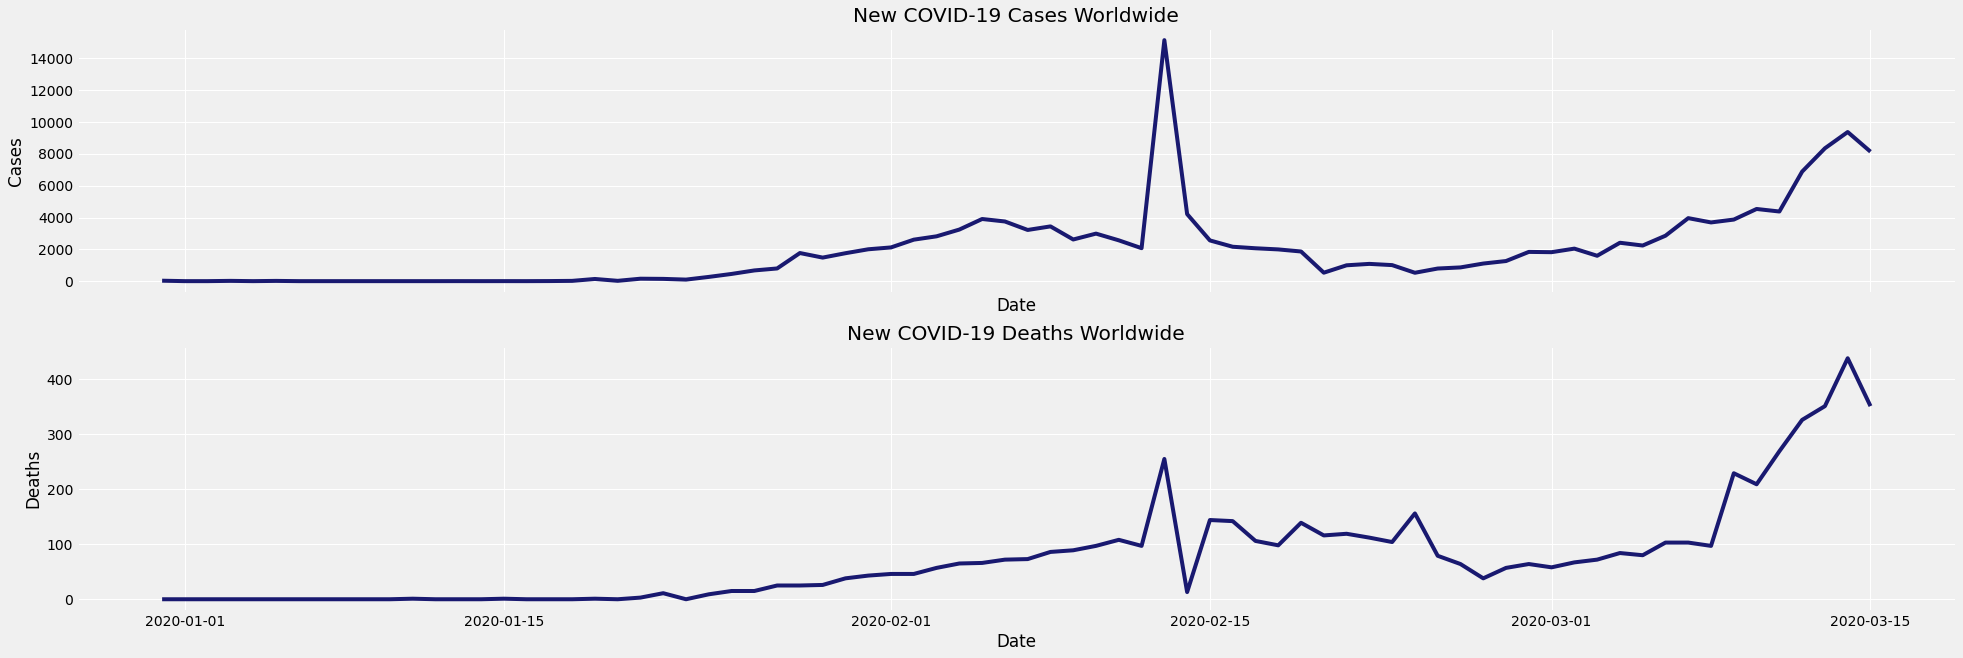

In [263]:
# plotting new cases by day worldwide
plt.rcParams['figure.figsize'] = [30, 10]
fig, ax = plt.subplots(2,sharex=True)
# top chart of cases
ax[0].plot(wc['DATE_REP'], wc['NEW_CASES'],color="midnightblue")
ax[0].set(xlabel='Date', ylabel='Cases',
       title='New COVID-19 Cases Worldwide')
ax[0].grid(color='white')

# bottom chart of deaths
ax[1].plot(wc['DATE_REP'], wc['NEW_DEATHS'],color="midnightblue")
ax[1].set(xlabel='Date', ylabel='Deaths',
       title='New COVID-19 Deaths Worldwide')
ax[1].grid(color='white')

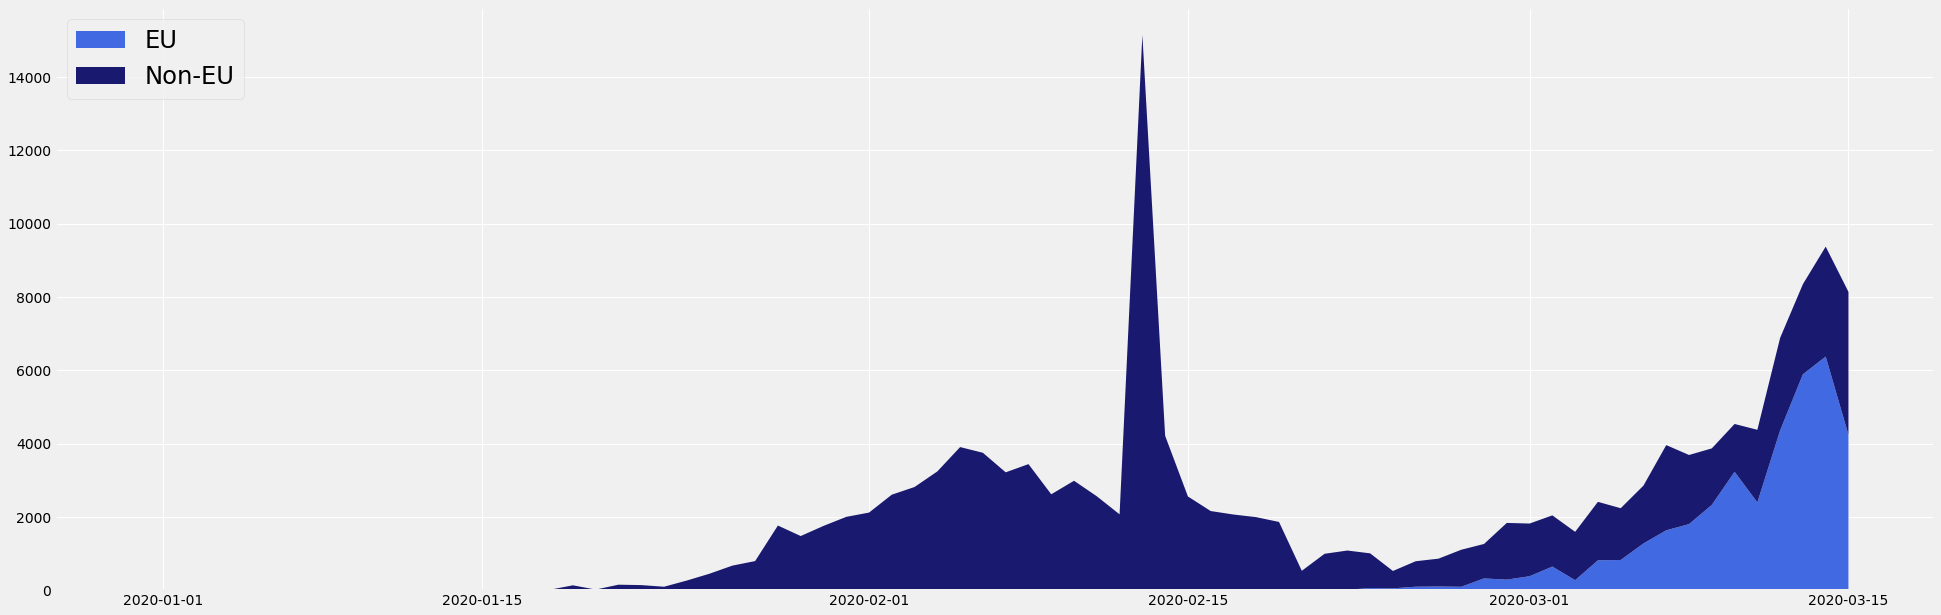

In [259]:
# plotting EU vs. Non-EU New Cases
fig, ax = plt.subplots()
ax.stackplot(eu['DATE_REP'].drop_duplicates(),eu_y,
             labels=['EU','Non-EU'],
             colors=["royalblue", "midnightblue"])
ax.legend(loc='upper left', fontsize = "xx-large")
ax.grid(color="white")